In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

In [14]:
df_train = pd.read_csv('train_clf.csv')
df_test = pd.read_csv('test_clf.csv')

In [15]:
columns = ['a', 'b', 'c']
x_train = df_train[columns].values
x_means = x_train.mean(axis=0)
x_1 = (x_train - x_means)
y_train = df_train['y']
x_test = df_test[columns].values

In [16]:
with pm.Model() as model_1:
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10)
    β = pm.Normal('β', mu=0, sigma=2, shape=len(columns))

    μ = α_tmp + pm.math.dot(x_1, β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    α = pm.Deterministic('α', α_tmp - pm.math.dot(β,x_means))
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * (x_1[:,0]+x_means[0]))

    yl = pm.Bernoulli('yl', p=θ, observed=y_train)

    trace_1 = pm.sample(1000, chains = 4, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_tmp, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [17]:
az.summary(trace_1, var_names=['α','β'] )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,20.060,5.438,10.722,30.010,0.120,0.092,2353.0,2188.0,1.0
β[0],-2.340,1.211,-4.668,-0.178,0.042,0.029,850.0,1701.0,1.0
β[1],-1.856,1.159,-3.972,0.293,0.034,0.025,1191.0,1729.0,1.0
β[2],0.034,1.065,-1.955,2.007,0.035,0.025,909.0,1339.0,1.0


In [18]:
alpha_ = trace_1.posterior['α'].mean(("chain", "draw")).values
beta_ = trace_1.posterior["β"].mean(("chain", "draw")).values

pred = np.dot(x_test, beta_) + alpha_
pred_probabilities = 1 / (1 + np.exp(-pred))
y_pred = (pred_probabilities > 0.5).astype(int)

In [19]:
y_pred

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [20]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, y_pred)

0.96

# Задание 2

In [21]:
column = 'a'
x_a = df_test['a'].values

In [22]:
with pm.Model() as lda:
    μ = pm.Normal('μ', mu=0, sigma=20, shape=2)
    σ = pm.HalfNormal('σ', 10, shape=2)
    setosa = pm.Normal('setosa', mu=μ[0], sigma=σ[0], observed=x_a[:50])
    versicolor = pm.Normal('versicolor', mu=μ[1], sigma=σ[1], observed=x_a[50:])

    bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
    trace_lda = pm.sample(2000, chains = 4, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.


In [23]:
posterior_lda = trace_lda.posterior.stack(samples=("chain", "draw"))

In [24]:
az.summary(trace_lda)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],4.612,0.377,3.891,5.318,0.003,0.002,11903.0,6543.0,1.0
μ[1],4.696,0.354,4.061,5.373,0.003,0.002,10308.0,6223.0,1.0
σ[0],2.654,0.277,2.161,3.193,0.003,0.002,12680.0,6674.0,1.0
σ[1],2.485,0.257,2.040,2.984,0.003,0.002,11140.0,6756.0,1.0
bd,4.654,0.258,4.170,5.140,0.002,0.002,11299.0,6966.0,1.0


/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


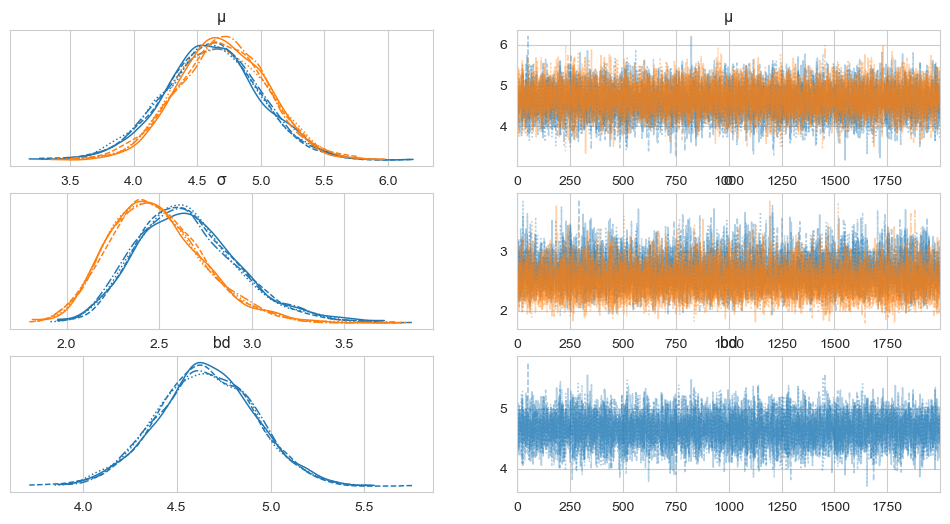

In [25]:
az.plot_trace(trace_lda,compact=True);